In [1]:
%pylab inline
import repsci
from matplotlib import pyplot as plt
import networkx as nx
from networkx import bipartite
from networkx import NetworkXNoPath
import random
import scipy.stats as spstats
import tqdm
from netdelib.topologies.topologies import *
exp = repsci.Experiment('connectivity')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_layer_graph(stage_pods, self_weight=0, source=False, sink=False):
    '''
    stage_pods: [stage][pod][node]'''
    G = nx.DiGraph()
    all_nodes = [
        elt
        for pod in stage_pods[0]
            for elt in pod]
    final_stage = len(stage_pods)
    for stage, pods in enumerate(stage_pods):
        for pod in pods:
            for v in pod:
                if source:
                    # Create labels for source node
                    i_label = '0-{}'.format(v)
                    # Add zero-weight shortcut edges to nodes after stage
                    t_label = '{}-{}'.format(stage + 1, v)
                    G.add_edge(i_label, t_label, weight=0)
                if sink:
                    # Create labels for sink nodes
                    f_label = '{}-{}'.format(final_stage, v)
                    # Add zero-weight shortcut edges to nodes before stage
                    s_label = '{}-{}'.format(stage, v)
                    G.add_edge(s_label, f_label, weight=0)
                for w in pod:
                    if v == w:
                        continue
                    # Create labels for target nodes
                    s_label = '{}-{}'.format(stage, v)
                    t_label = '{}-{}'.format(stage + 1, w)
                    G.add_edge(s_label, t_label, weight=1)
    return G

In [3]:
def test_residue(M=5, D=3, all_N=range(20,80), lowest=2, link_adjacent=False):
    '''Tests connectiity of long-path networks, considering only paths starting at t0.'''
    result = {
        'harmonic': [],
        'finite': [],
        'bounded': [],
        'kcon': []
    }
    # Iterate through network sizes
    for N in tqdm.tqdm(all_N):
        # Initialize totals
        harmonic_total = 0
        kcon_total = 0
        # Generate graph from list of groups at each stage
        # Stage 0 groups adjacent nodes, treating all as the same modulus class
        if link_adjacent:
            lower = 0
            upper = D
        else:
            lower = 1
            upper = D + 1
        stage_groups = [
            get_long_path_stage_groups(N, M, i, lowest=lowest)
            for i in range(lower, upper)]
        G_residue = get_layer_graph(stage_groups, self_weight=1, source=True, sink=True)
        residue_lengths = []
        finite_lengths = []
        bounded_lengths = []
        for s in range(N):
            # Construct source label and get all shortests paths from it
            s_id = '0-{}'.format(s)
            s_lengths = nx.shortest_path_length(
                G_residue, source=s_id, weight='weight')
            for t in range(N):
                if s == t:
                    continue
                # Find path length from first stage to end-stage
                t_id = '{}-{}'.format(D, t)
                try:
                    length = s_lengths[t_id]
                    residue_lengths.append(length)
                    finite_lengths.append(length)
                    bounded_lengths.append(length)
                    kcon_total += 1
                except KeyError:
                    residue_lengths.append(float('inf'))
                    bounded_lengths.append(D + 1)
        harmonic_total += spstats.hmean(residue_lengths)
        result['harmonic'].append(harmonic_total)
        result['finite'].append(sum(finite_lengths) / len(finite_lengths))
        result['bounded'].append(sum(bounded_lengths) / len(bounded_lengths))
        result['harmonic'].append(harmonic_total)
        result['kcon'].append(kcon_total / N / (N - 1))
    return result

In [4]:
def test_random(M=5, D=3, all_N=range(20,80), num_iter=10):
    '''Tests connectiity of random-pod networks, considering only paths starting at t0.'''
    result = {
        'harmonic': [],
        'finite': [],
        'bounded': [],
        'kcon': []
    }
    # Iterate through network sizes
    for N in tqdm.tqdm(all_N):
        # Initialize totals
        harmonic_total = 0
        kcon_total = 0
        finite_total = 0
        bounded_total = 0
        # Run multiple trials
        for m in range(num_iter):
            # Generate graph from list of groups at each stage
            stage_groups = [
                get_random_stage_groups(N, M, i)
                for i in range(D)]
            G_random = get_layer_graph(stage_groups, self_weight=1, source=False, sink=True)
            random_lengths = []
            finite_lengths = []
            bounded_lengths = []
            for s in range(N):
                # Construct source label and get all shortests paths from it
                s_id = '0-{}'.format(s)
                s_lengths = nx.shortest_path_length(
                            G_random, source=s_id, weight='weight')
                for t in range(N):
                    if s == t:
                        continue
                    # Find path length from first stage to end-stage
                    s_id = '0-{}'.format(s)
                    t_id = '{}-{}'.format(D, t)
                    try:
                        length = s_lengths[t_id]
                        random_lengths.append(length)
                        finite_lengths.append(length)
                        bounded_lengths.append(length)
                        kcon_total += 1
                    except KeyError:
                        random_lengths.append(float('inf'))
                        bounded_lengths.append(D + 1)
            harmonic_total += spstats.hmean(random_lengths)
            bounded_total += sum(bounded_lengths) / len(bounded_lengths)
            finite_total += sum(finite_lengths) / len(finite_lengths)
        result['harmonic'].append(harmonic_total / num_iter)
        result['finite'].append(finite_total / num_iter)
        result['bounded'].append(bounded_total / num_iter)
        result['kcon'].append(kcon_total / N / (N - 1) / num_iter)
    return result

In [5]:
def test_residue_all_stages(M=5, D=3, all_N=range(20,80), lowest=2, link_adjacent=False):
    '''Tests connectiity of long-path networks,
    considering all paths starting and ending on any stage.'''
    result = {
        'harmonic': [],
        'kcon': []
    }
    # Iterate through network sizes
    for N in tqdm.tqdm(all_N):
        # Initialize totals
        harmonic_total = 0
        kcon_total = 0
        possible_total = 0
        # Generate graph from list of groups at each stage
        # Stage 0 groups adjacent nodes, treating all as the same modulus class
        if link_adjacent:
            lower = 0
            upper = D
        else:
            lower = 1
            upper = D + 1
        stage_groups = [
            get_long_path_stage_groups(N, M, i, lowest=lowest)
            for i in range(lower, upper)]
        G_residue = get_layer_graph(stage_groups, self_weight=0, sink_source=False)
        residue_lengths = []
        for s_stage in range(D):
            for t_stage in range(s_stage + 1, D+1):
                for s in range(N):
                    for t in range(N):
                        possible_total += 1
                        # Find path length from first stage to end-stage
                        s_id = '{}-{}'.format(s_stage, s)
                        t_id = '{}-{}'.format(t_stage, t)
                        try:
                            length = nx.shortest_path_length(
                                G_residue, s_id, t_id, weight='weight')
                            residue_lengths.append(length)
                            kcon_total += 1
                        except NetworkXNoPath:
                            residue_lengths.append(float('inf'))
        harmonic_total += spstats.hmean(residue_lengths)
        result['harmonic'].append(harmonic_total)
        result['kcon'].append(kcon_total / possible_total)
    return result

In [6]:
def test_random_all_stages(M=5, D=3, all_N=range(20,80), num_iter=10):
    '''Tests connectiity of random-pod networks,
    considering all paths starting and ending on any stage.'''
    result = {
        'harmonic': [],
        'kcon': []
    }
    # Iterate through network sizes
    for N in tqdm.tqdm(all_N):
        # Initialize totals
        harmonic_total = 0
        kcon_total = 0
        possible_total = 0
        # Run multiple trials
        for m in range(num_iter):
            # Generate graph from list of groups at each stage
            stage_groups = [
                get_random_stage_groups(N, M, i)
                for i in range(D)]
            G_random = get_layer_graph(stage_groups, self_weight=0, sink_source=False)
            random_lengths = []
            for s_stage in range(D):
                for t_stage in range(s_stage + 1, D + 1):
                    for s in range(N):
                        for t in range(N):
                            possible_total += 1
                            # Find path length from first stage to end-stage
                            s_id = '{}-{}'.format(s_stage, s)
                            t_id = '{}-{}'.format(t_stage, t)
                            try:
                                length = nx.shortest_path_length(
                                    G_random, s_id, t_id, weight='weight')
                                random_lengths.append(length)
                                kcon_total += 1
                            except NetworkXNoPath:
                                random_lengths.append(float('inf'))
            harmonic_total += spstats.hmean(random_lengths)
        result['harmonic'].append(harmonic_total / num_iter)
        result['kcon'].append(kcon_total / possible_total)
    return result

In [7]:
M=5
D=3
lowest=2
step=1
all_N = range(15, 50, step)
residue_result = test_residue(M=M, D=D, all_N=all_N, lowest=lowest, link_adjacent=True)

100%|██████████████████████████████████████████| 35/35 [00:00<00:00, 247.82it/s]


In [8]:
random_result = test_random(M=M, D=D, all_N=all_N)

100%|███████████████████████████████████████████| 35/35 [00:01<00:00, 24.44it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


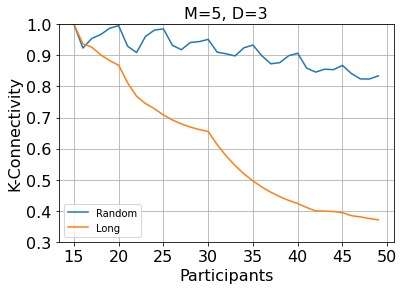

In [9]:
plt.figure(figsize=(6,4))
plt.title("M={}, D={}".format(M, D), fontsize=16)
plt.plot(all_N, random_result['kcon'], label="Random")
plt.plot(all_N, residue_result['kcon'], label="Long")
plt.legend(loc="lower left")
plt.xlabel("Participants", fontsize=16)
plt.ylabel("K-Connectivity", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.ylim([0.3,1])
plt.yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.tight_layout
plt.savefig(exp.get_filename('kcon.png'), dpi=600)
plt.savefig(exp.get_filename('kcon.eps'))